In [1]:
import torch
import timeit
import matplotlib.pyplot as plt
import numpy as np

from pprint import pprint
from copy import deepcopy as dc

from matplotlib import rc
from matplotlib.font_manager import FontProperties

# Put Matplotlib into notebook mode and change the font.
# If LaTeX x MatPlotLib is not configured on your machine, then comment this section.
# %matplotlib notebook
rc('font',**{'family':'serif',
             'serif':['Palatino'], 
             'size': 8,})
rc('text', usetex=True)

# Change the dimensions of the notebook to fit window,
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

import pandas as pd 
import wandb
api = wandb.Api()

from pathlib import Path
home = str(Path.home())

# Define the standard plotting colours.
color_names = [
    "tab:blue",
    "tab:orange",
    "tab:green",
    "tab:red",
    "tab:purple",
    "tab:brown",
    "tab:pink",
    "tab:gray",
    "tab:olive",
    "tab:cyan"
] * 10

# Some other colour / visual settings.
fill_alpha = 0.2
main_line_width = 1.0
edge_alpha = 0.5

# Paper and figure size.
column_width = 3.25  # INCHES.

fig_size_onecol = [column_width * 1.00,  # Width.
                   column_width * 0.60]  # Height.

fig_size_hlfcol = [column_width * 0.48,  # Width. 
                   column_width * 0.60]  # Height.

fig_size_twocol = [column_width * 2.00,  # Width. 
                   column_width * 0.60]  # Height.

label_gen = lambda __str, __i=0: __str if __i == 0 else None

# Get individual run.

In [2]:
def get_experiment_from_wandb(project, exp_tag, exp_key=None, exp_val=None):

    print(exp_tag)
    column_names = ''
    
    # Grab all the runs.
    runs = api.runs(project)
    filtered_runs = []
    filtered_histories = []
    for _run in runs: 
        try:
            # if _run.config['group'] == exp_tag:
            if _run.group == exp_tag:
                filtered_runs.append(_run)
                _hist = _run.history(samples=99999999)
                filtered_histories.append(_hist)  # Run with some token large number to grab all the samples.  Can be very slow.
                column_names = _hist.columns
        except:
            pass
    print(len(filtered_runs))
    
    # Throw and error if there were no runs.
    if len(filtered_runs) == 0:
        raise RuntimeError("No experiments found.  Check the exp_tag.")


    # Now re-grab the runs and make sure they all share keys.
    key_runs = api.runs(project)
    keys = []
    for _run in key_runs: 
        try:
            if _run.group == exp_tag:
                keys.append(_run.scan_history().__next__().keys())
        except Exception as err:
            pass

    # print(keys)
    assert all([keys[0] == _k for _k in keys]), 'Keys are not shared.'
    
    # Go and get everything.
    values = []
    lengths = []
    for _hist in filtered_histories:
        _values = []
        for _v in _hist:
            _values.append(_v)
        values.append(_values)
        lengths.append(len(_values))
    min_Length = np.min(lengths)
        
    return values, min_Length, filtered_histories, column_names


In [3]:
# filtered_histories = run.history(samples=99999999)  # Run with some token large number to grab all the samples.  Can be very slow.
# filtered_histories = [_r.scan_history() for _r in filtered_runs]  # Default to using fewer samples.

plot_styles = ['-', '--', ':', '-.'] * 10

# Project is specified by <entity/project-name>
project = "andrewwarrington/fivo-aux-beta"

exp_tag = ['gdm-v3.0.3-fivo-aux', 'gdm-v3.0.6-fivo-aux-sgr']
exp_label = ['FIVO-AUX', 'FIVO-AUX-SGR']
save_tag = 'gdm-v3-0'

# exp_tag = ['debug', ]
# save_tag = 'debug'

filtered_histories = []
column_names = None
for _tag in exp_tag:
    _, _, _filtered_histories, column_names = get_experiment_from_wandb(project, _tag)
    filtered_histories.append(_filtered_histories)

pprint("Keys:")
pprint(list(filtered_histories[0][0].keys()))


gdm-v3.0.3-fivo-aux
5
gdm-v3.0.6-fivo-aux-sgr
5
'Keys:'
['step',
 'params_p_true.dynamics_bias',
 'params_p_pred.dynamics_bias',
 'small_lml_variance_fivo',
 '_step',
 'params_q_pred.head_mean_fn_bias',
 'params_r_pred.head_mean_fn_kernel',
 'small_lml_variance_bpf_true',
 'params_r_pred.head_mean_fn_bias',
 'params_q_pred.head_mean_fn_kernel',
 'small_lml_mean_em_true',
 'params_r_pred.head_log_var_fn_bias_(EXP)',
 'params_q_pred.head_log_var_fn_bias_(EXP)',
 'expected_kl_true',
 'expected_kl_pred',
 '_runtime',
 'small_fivo_bound',
 'epoch',
 'small_lml_mean_bpf_true',
 'pred_fivo_bound',
 'pred_lml',
 'small_lml_mean_fivo',
 '_timestamp']


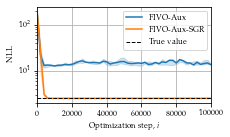

In [4]:
# NOTE - we store the true lml in this field.
# NOTE - these should all evalaute to the same quantity. TODO
# NOTE - maybe shift this to use true_lml

true_loss_key = 'small_lml_mean_bpf_true'
fivo_aux_key = 'small_lml_mean_fivo'

# Get the loss.
# True loss.
true_lml = np.log(np.mean(np.exp([_h.get(true_loss_key) for _h in filtered_histories[0]])))

# Fivo aux.
fivo_aux_lml = []
for _j in range(len(filtered_histories[0])):
    fivo_aux_lml.append(np.stack(filtered_histories[0][_j].get(fivo_aux_key).values.squeeze()))
fivo_aux_lml = np.stack(fivo_aux_lml).squeeze()
fivo_aux_lml_mu = np.quantile(fivo_aux_lml, 0.50, axis=0)
fivo_aux_lml_lq = np.quantile(fivo_aux_lml, 0.25, axis=0)
fivo_aux_lml_uq = np.quantile(fivo_aux_lml, 0.75, axis=0)

# Fivo aux sgr.
fivo_aux_sgr_lml = []
for _j in range(len(filtered_histories[1])):
    fivo_aux_sgr_lml.append(np.stack(filtered_histories[1][_j].get(fivo_aux_key).values.squeeze()))
fivo_aux_sgr_lml = np.stack(fivo_aux_sgr_lml).squeeze()
fivo_aux_sgr_lml_mu = np.quantile(fivo_aux_sgr_lml, 0.50, axis=0)
fivo_aux_sgr_lml_lq = np.quantile(fivo_aux_sgr_lml, 0.25, axis=0)
fivo_aux_sgr_lml_uq = np.quantile(fivo_aux_sgr_lml, 0.75, axis=0)

# Set up the x points.
x = filtered_histories[0][0].get('step').values.squeeze()

# Build the figure.
f = plt.figure(figsize=fig_size_onecol)

# Plot the stuff.
plt.plot(x, fivo_aux_lml_mu, c=color_names[0], label='FIVO-Aux')
plt.fill_between(x, fivo_aux_lml_lq, fivo_aux_lml_uq, color=color_names[0], alpha=fill_alpha)

plt.plot(x, fivo_aux_sgr_lml_mu, c=color_names[1], label='FIVO-Aux-SGR')
plt.fill_between(x, fivo_aux_sgr_lml_lq, fivo_aux_sgr_lml_uq, color=color_names[1], alpha=fill_alpha)

plt.plot([np.min(x), np.max(x)], [true_lml, true_lml], c='k', linestyle='--', linewidth=main_line_width, label='True value')

# Set up x axis.
plt.xlim([0, np.max(x)])
plt.xlabel('Optimization step, $i$')

# Set up y axis.
plt.ylabel(r'NLL')

# Set up legend.
plt.legend()

# Do menial stuff.
plt.grid(True)
plt.tight_layout()
plt.yscale('log')

# Save out.
plt.savefig(home + '/Downloads/{}_loss.pdf'.format(save_tag))


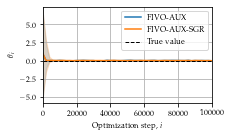

In [5]:
true_param_key = 'params_p_true.dynamics_bias'
fivo_param_key = 'params_p_pred.dynamics_bias'

# Get the params.
# True param.
true_param = np.mean(filtered_histories[0][0].get(true_param_key))

# Fivo aux.
fivo_aux_param = []
for _j in range(len(filtered_histories[0])):
    fivo_aux_param.append(np.stack(filtered_histories[0][_j].get(fivo_param_key).values.squeeze()))
fivo_aux_param = np.stack(fivo_aux_param).squeeze()
fivo_aux_param_mu = np.quantile(fivo_aux_param, 0.50, axis=0)
fivo_aux_param_lq = np.quantile(fivo_aux_param, 0.25, axis=0)
fivo_aux_param_uq = np.quantile(fivo_aux_param, 0.75, axis=0)

# Fivo aux sgr.
fivo_aux_sgr_param = []
for _j in range(len(filtered_histories[1])):
    fivo_aux_sgr_param.append(np.stack(filtered_histories[1][_j].get(fivo_param_key).values.squeeze()))
fivo_aux_sgr_param = np.stack(fivo_aux_sgr_param).squeeze()
fivo_aux_sgr_param_mu = np.quantile(fivo_aux_sgr_param, 0.50, axis=0)
fivo_aux_sgr_param_lq = np.quantile(fivo_aux_sgr_param, 0.25, axis=0)
fivo_aux_sgr_param_uq = np.quantile(fivo_aux_sgr_param, 0.75, axis=0)

# Set up the x points.
x = filtered_histories[0][0].get('step').values.squeeze()

# Build the figure.
f = plt.figure(figsize=fig_size_onecol)

# Plot the stuff.
plt.plot(x, fivo_aux_param_mu, c=color_names[0], label=exp_label[0])
plt.fill_between(x, fivo_aux_param_lq, fivo_aux_param_uq, color=color_names[0], alpha=fill_alpha)

plt.plot(x, fivo_aux_sgr_param_mu, c=color_names[1], label=exp_label[1])
plt.fill_between(x, fivo_aux_sgr_param_lq, fivo_aux_sgr_param_uq, color=color_names[1], alpha=fill_alpha)

plt.plot([np.min(x), np.max(x)], [true_param, true_param], c='k', linestyle='--', linewidth=main_line_width, label='True value')

# Set up x axis.
plt.xlim([0, np.max(x)])
plt.xlabel('Optimization step, $i$')

# Set up y axis.
plt.ylabel(r'$\theta_i$')
# plt.yscale('symlog')

# Set up legend.
plt.legend()

# Do menial stuff.
plt.grid(True)
plt.tight_layout()

# Save out.
plt.savefig(home + '/Downloads/{}_param.pdf'.format(save_tag))



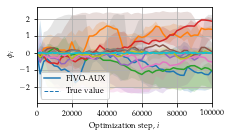

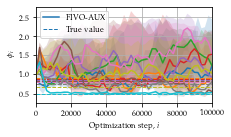

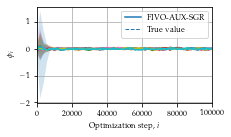

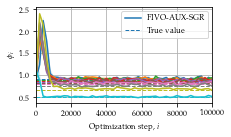

In [6]:
n_opt_evals = len(filtered_histories[0][0].get(true_param_key))
T = 10
t = np.arange(1, T+1)  # There are ten time steps.

## Proposal.

keys = [#'params_q_pred.head_mean_fn_kernel',   # TODO - need to make this able to deal with multiple params.
        'params_q_pred.head_mean_fn_bias', 
        'params_q_pred.head_log_var_fn_bias_(EXP)']

true_vals = [#np.ones((n_opt_evals, )),
             np.zeros((n_opt_evals, )),
             (T - t + 1) / (T - t + 2)]

for _j, _e in enumerate(exp_tag):
    for _i, _k in enumerate(keys):
        # Get the param.
        # True.
        true_param = true_vals[_i]

        # Fivo aux.
        fivo_aux_param = []
        for __j in range(len(filtered_histories[_j])):
            fivo_aux_param.append(np.stack(filtered_histories[_j][__j].get(_k).values.squeeze()))
        fivo_aux_param = np.stack(fivo_aux_param).squeeze()
        fivo_aux_param_mu = np.quantile(fivo_aux_param, 0.50, axis=0)
        fivo_aux_param_lq = np.quantile(fivo_aux_param, 0.25, axis=0)
        fivo_aux_param_uq = np.quantile(fivo_aux_param, 0.75, axis=0)

        # Set up the x points.
        x = filtered_histories[0][0].get('step').values.squeeze()

        # Build the figure.
        fig = plt.figure(figsize=fig_size_onecol)

        # Plot the stuff.
        for __i, (_m, _l, _u) in enumerate(zip(fivo_aux_param_mu.T, fivo_aux_param_lq.T, fivo_aux_param_uq.T)):
            plt.plot(x, _m, c=color_names[__i], label=label_gen(exp_label[_j], __i))
            plt.fill_between(x, _l, _u, alpha=fill_alpha, facecolor=color_names[__i])

            plt.plot([np.min(x), np.max(x)], [true_param[__i], true_param[__i]], c=color_names[__i], linestyle='--', linewidth=main_line_width, label=label_gen('True value', __i))

        plt.grid(True)

        # Set up x axis.
        plt.xlim([0, np.max(x)])
        plt.xlabel('Optimization step, $i$')
        # plt.xscale('log')

        # Set up y axis.
        plt.ylabel(r'$\phi_i$')
        # plt.yscale('symlog')

        # Set up legend.
        plt.legend()

        # Do menial stuff.
        plt.tight_layout()

        # Save out.
        plt.savefig(home + '/Downloads/{}_q_{}_{}.pdf'.format(save_tag, _e, _k))




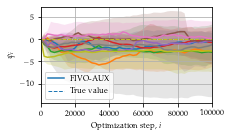

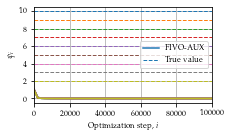

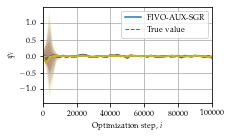

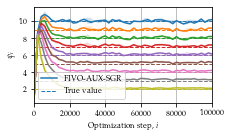

In [7]:
n_opt_evals = len(filtered_histories[0][0].get(true_param_key))
T = 10
t = np.arange(1, T+1)  # There are ten time steps.

## Proposal.

keys = [#'params_q_pred.head_mean_fn_kernel',   # TODO - need to make this able to deal with multiple params.
        'params_r_pred.head_mean_fn_bias', 
        'params_r_pred.head_log_var_fn_bias_(EXP)']

true_vals = [#np.ones((n_opt_evals, )),
             np.zeros((n_opt_evals, )),
             list(reversed(np.arange(2, T+1)))]

for _j, _e in enumerate(exp_tag):
    for _i, _k in enumerate(keys):
        # Get the param.
        # True.
        true_param = true_vals[_i]

        # Fivo aux.
        fivo_aux_param = []
        for __j in range(len(filtered_histories[_j])):
            fivo_aux_param.append(np.stack(filtered_histories[_j][__j].get(_k).values.squeeze()))
        fivo_aux_param = np.stack(fivo_aux_param).squeeze()
        fivo_aux_param_mu = np.quantile(fivo_aux_param, 0.50, axis=0)
        fivo_aux_param_lq = np.quantile(fivo_aux_param, 0.25, axis=0)
        fivo_aux_param_uq = np.quantile(fivo_aux_param, 0.75, axis=0)

        # Set up the x points.
        x = filtered_histories[0][0].get('step').values.squeeze()

        # Build the figure.
        fig = plt.figure(figsize=fig_size_onecol)

        # Plot the stuff.
        for __i, (_m, _l, _u) in enumerate(zip(fivo_aux_param_mu.T, fivo_aux_param_lq.T, fivo_aux_param_uq.T)):
            plt.plot(x, _m, c=color_names[__i], label=label_gen(exp_label[_j], __i))
            plt.fill_between(x, _l, _u, alpha=fill_alpha, facecolor=color_names[__i])

            plt.plot([np.min(x), np.max(x)], [true_param[__i], true_param[__i]], c=color_names[__i], linestyle='--', linewidth=main_line_width, label=label_gen('True value', __i))

        plt.grid(True)

        # Set up x axis.
        plt.xlim([0, np.max(x)])
        plt.xlabel('Optimization step, $i$')

        # Set up y axis.
        plt.ylabel(r'$\psi_i$')
        # plt.yscale('symlog')

        # Set up legend.
        plt.legend()

        # Do menial stuff.
        plt.tight_layout()

        # Save out.
        plt.savefig(home + '/Downloads/{}_r_{}_{}.pdf'.format(save_tag, _e, _k))





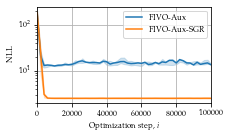

In [8]:

true_kl_key = 'expected_kl_true'
fivo_kl_key = 'expected_kl_pred'

# Get the KLs.

# Fivo aux.
true_kl = []
for _j in range(len(filtered_histories[0])):
    true_kl.append(np.stack(filtered_histories[0][_j].get(true_kl_key).values.squeeze()))
true_kl = np.stack(true_kl).squeeze()
true_kl_mu = np.quantile(true_kl, 0.50, axis=0)
true_kl_lq = np.quantile(true_kl, 0.25, axis=0)
true_kl_uq = np.quantile(true_kl, 0.75, axis=0)

# Fivo aux sgr.
fivo_aux_sgr_kl = []
for _j in range(len(filtered_histories[1])):
    fivo_aux_sgr_kl.append(np.stack(filtered_histories[1][_j].get(fivo_kl_key).values.squeeze()))
fivo_aux_sgr_kl = np.stack(fivo_aux_sgr_lml).squeeze()
fivo_aux_sgr_kl_mu = np.quantile(fivo_aux_sgr_kl, 0.50, axis=0)
fivo_aux_sgr_kl_lq = np.quantile(fivo_aux_sgr_kl, 0.25, axis=0)
fivo_aux_sgr_kl_uq = np.quantile(fivo_aux_sgr_kl, 0.75, axis=0)

# Set up the x points.
x = filtered_histories[0][0].get('step').values.squeeze()

# Build the figure.
f = plt.figure(figsize=fig_size_onecol)

# Plot the stuff.
plt.plot(x, fivo_aux_lml_mu, c=color_names[0], label='FIVO-Aux')
plt.fill_between(x, fivo_aux_lml_lq, fivo_aux_lml_uq, color=color_names[0], alpha=fill_alpha)

plt.plot(x, fivo_aux_sgr_lml_mu, c=color_names[1], label='FIVO-Aux-SGR')
plt.fill_between(x, fivo_aux_sgr_lml_lq, fivo_aux_sgr_lml_uq, color=color_names[1], alpha=fill_alpha)

# plt.plot([np.min(x), np.max(x)], [true_lml, true_lml], c='k', linestyle='--', linewidth=main_line_width, label='True value')

# Set up x axis.
plt.xlim([0, np.max(x)])
plt.xlabel('Optimization step, $i$')

# Set up y axis.
plt.ylabel(r'NLL')

# Set up legend.
plt.legend()

# Do menial stuff.
plt.grid(True)
plt.tight_layout()
plt.yscale('log')

# Save out.
plt.savefig(home + '/Downloads/{}_KL.pdf'.format(save_tag))



In [9]:
fivo_aux_param_uq.shape

(51, 9)

In [10]:
# # OLD-ISH CODE FOR USING SUBPLOTS.

# n_opt_evals = len(filtered_histories[0][0].get(true_param_key))
# T = 10
# t = np.arange(1, T+1)  # There are ten time steps.

# ## Proposal.

# keys = [#'params_q_pred.head_mean_fn_kernel',   # TODO - need to make this able to deal with multiple params.
#         'params_q_pred.head_mean_fn_bias', 
#         'params_q_pred.head_log_var_fn_bias_(EXP)']

# true_vals = [#np.ones((n_opt_evals, )),
#              np.zeros((n_opt_evals, )),
#              (T - t + 1) / (T - t + 2)]

# for _i, _k in enumerate(keys):
#     # Get the param.
#     # True.
#     true_param = true_vals[_i]

#     # Fivo aux.
#     fivo_aux_param = []
#     for _j in range(len(filtered_histories[0])):
#         fivo_aux_param.append(np.stack(filtered_histories[0][_j].get(_k).values.squeeze()))
#     fivo_aux_param = np.stack(fivo_aux_param).squeeze()
#     fivo_aux_param_mu = np.quantile(fivo_aux_param, 0.50, axis=0)
#     fivo_aux_param_lq = np.quantile(fivo_aux_param, 0.25, axis=0)
#     fivo_aux_param_uq = np.quantile(fivo_aux_param, 0.75, axis=0)

#     # Fivo aux sgr.
#     fivo_aux_sgr_param = []
#     for _j in range(len(filtered_histories[1])):
#         fivo_aux_sgr_param.append(np.stack(filtered_histories[1][_j].get(_k).values.squeeze()))
#     fivo_aux_sgr_param = np.stack(fivo_aux_sgr_param).squeeze()
#     fivo_aux_sgr_param_mu = np.quantile(fivo_aux_sgr_param, 0.50, axis=0)
#     fivo_aux_sgr_param_lq = np.quantile(fivo_aux_sgr_param, 0.25, axis=0)
#     fivo_aux_sgr_param_uq = np.quantile(fivo_aux_sgr_param, 0.75, axis=0)

#     # Set up the x points.
#     x = filtered_histories[0][0].get('step').values.squeeze()

#     # Build the figure.
#     fig, axes = plt.subplots(1, 5, figsize=fig_size_twocol, sharex=True, sharey=True, squeeze=True)

#     # Plot the stuff.
#     for _ax_idx, _i in enumerate([0, 2, 4, 6, 8]):
#         axes[_ax_idx].plot(x, fivo_aux_param_mu[:, _i], c=color_names[0], label='FIVO-Aux')
#         axes[_ax_idx].fill_between(x, fivo_aux_param_lq[:, _i], fivo_aux_param_uq[:, _i], color=color_names[0], alpha=fill_alpha)

#         axes[_ax_idx].plot(x, fivo_aux_sgr_param_mu[:, _i], c=color_names[1], label='FIVO-Aux-SGR')
#         axes[_ax_idx].fill_between(x, fivo_aux_sgr_param_lq[:, _i], fivo_aux_sgr_param_uq[:, _i], color=color_names[1], alpha=fill_alpha)

#         axes[_ax_idx].plot([np.min(x), np.max(x)], [true_param[_i], true_param[_i]], c='k', linestyle='--', linewidth=main_line_width, label='True value')

#         axes[_ax_idx].grid(True)
        
#     # Set up x axis.
#     axes[0].set_xlim([0, np.max(x)])
#     axes[2].set_xlabel('Optimization step, $i$')

#     # Set up y axis.
#     axes[0].set_ylabel(r'$\phi_i$')
#     plt.yscale('symlog')

#     # Set up legend.
#     axes[0].legend()

#     # Do menial stuff.
#     plt.tight_layout()

#     # Save out.
#     plt.savefig(home + '/Downloads/{}_q_{}.pdf'.format(save_tag, _k))


